In [1]:
#Load the data using pandas
#Import all the required packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

#Reading the file into pandas
Bank = pd.read_csv('bank-additional.csv',header = 0,delimiter = ';')
    
#print("Numerical variables\n\n",Bank.describe())
#print("\nCategorical variables\n\n",Bank.describe(include = ['O']))
#print(Bank['y'].unique())

#Converting discrete values to categorical variable datatype
col = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for each in col:
    Bank[each] = Bank[each].astype('category') 
print(Bank.shape)

(4119, 21)


In [2]:
#1.Converting non-numeric values to numric values; Hot-one encoding
Bank = pd.get_dummies(Bank,drop_first = True)
print(Bank.describe())

               age     duration     campaign        pdays     previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000   999.000000     0.000000   
75%      47.000000   317.000000     3.000000   999.000000     0.000000   
max      88.000000  3643.000000    35.000000   999.000000     6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed  \
count   4119.000000     4119.000000    4119.000000  4119.000000  4119.000000   
mean       0.084972       93.579704     -40.499102     3.621356  5166.481695   
std        1.563114        0.579349       4.594578     1.733591    73.667904   
min       -3.

In [3]:
#2.hecking for na values in any rows
print("NA's present : ",Bank.isnull().any().any())

NA's present :  False


In [4]:
#3. Split the data into test and train
#Generate a random list of true and false and assign train and test based on those values
split = np.random.rand(len(Bank)) < 0.8
#Assign train to true
train = Bank[split]
#Assign test to false
test = Bank[~split]

print("Train shape : ",train.shape,"\nTest shape : ",test.shape)
print(train.describe())

Train shape :  (3291, 54) 
Test shape :  (828, 54)
               age     duration     campaign        pdays     previous  \
count  3291.000000  3291.000000  3291.000000  3291.000000  3291.000000   
mean     39.972957   256.457308     2.533880   957.950471     0.195989   
std      10.285892   255.661809     2.554629   197.746038     0.549824   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   105.000000     1.000000   999.000000     0.000000   
50%      38.000000   180.000000     2.000000   999.000000     0.000000   
75%      47.000000   317.000000     3.000000   999.000000     0.000000   
max      88.000000  3643.000000    35.000000   999.000000     6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed  \
count   3291.000000     3291.000000    3291.000000  3291.000000  3291.000000   
mean       0.082407       93.578784     -40.440626     3.619861  5166.237466   
std        1.565375        0.578869       

In [5]:
#Seperating x and y data
xTrain = train.loc[:,train.columns != 'y_yes']
yTrain = train.loc[:,train.columns == 'y_yes']
xTest = test.loc[:,test.columns != 'y_yes']
yTest = test.loc[:,test.columns == 'y_yes']

#Normalizing the data
numerical = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
for each in numerical:
    xTrain[each] = (xTrain[each] - xTrain[each].min())/(xTrain[each].max()-xTrain[each].min())
for each in xTest.columns.values:
    xTest[each] = (xTest[each] - xTest[each].min())/(xTest[each].max()-xTest[each].min())
    
    
#Adding bias to x data
xTrain = np.column_stack([xTrain,np.ones(len(xTrain))])
xTest = np.column_stack([xTest,np.ones(len(xTest))]) 


/home/kritz/anaconda3/envs/scripts/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [6]:
#To compute the sigmoid of x, beta
def sigmoid(X):
    dnr = 1.0 + np.e ** (-1.0 * X)
    return(1.0/dnr)

In [7]:
#Log - likelihood function
def logLikelihood(x, y, beta):
    scores = x.dot(beta)
    #print(x,beta)
    logLoss = np.sum(y*scores - np.log(1 + np.exp(scores)))
    return logLoss

In [8]:
#Bolddriver
def boldDriver(alpha,lossOld,lossNew):
    alphaPlus,alphaMinus = 1.2,0.9
    if float(lossNew < lossOld):
        return(alpha*alphaPlus)
    else:
        return(alpha*alphaMinus)

In [9]:
#Adaptive gradient
def adaGrad(gradient,history):
    alphaNew = np.random.rand(1,gradient.shape[1])
    #Storing the gradient history
    history += np.square(gradient)
    error,master_stepsize = 0.00001,0.0000001
    alphaNew = (alphaNew)/(np.sqrt(history)+error)
    return((master_stepsize*alphaNew),history)  

In [10]:
#Logistic regression
def logisticRegression(x,y,xt,yt,alpha,stepLength):
    beta = np.zeros((x.shape[1],1))
    ii = []
    ll =[]
    lloss = []
    history = 0.0
    for i in range(1000):
        scores = x.dot(beta)
        predictions = sigmoid(scores)
        #Updating using the gradient
        error = y - predictions
        gradient = x.T.dot(error)
        #Adagrad alpha updation
        if stepLength == "Adagrad":
            alpha,history = adaGrad(gradient,history)
        betaNew = beta + (alpha *( gradient))
        lossOld = logLikelihood(x,y,beta)
        lossNew = logLikelihood(x,y,betaNew)
        #print(lossOld,lossNew)
        logLoss = float(lossNew - lossOld)
        #Bold driver step length updation
        if stepLength == "Bold driver":
            alpha = boldDriver(alpha,lossOld,lossNew)
            betaNew = beta + (alpha* gradient)
        ii.append(i)
        ll.append(logLoss)
        lloss.append(y.T.dot(np.log(sigmoid(x.dot(beta)))) - (1-y).T.dot(np.log(1-sigmoid(x.dot(beta)))))
        if (logLoss < 0.0000000000000001):
            print("Optimal beta found",i+1,betaNew)
            break
        if(i == 999):
            print("Beta did not converge")
        beta = betaNew    
    plt.plot(ii,ll,color = 'green')
    plt.title("Iterations vs Difference in Objective function value")
    plt.xlabel("Iterations")
    plt.ylabel("Objective function value")
    plt.show()
    plt.plot(ii,lloss,color = 'blue')
    plt.title("Iterations vs Log Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Log Loss")
    plt.show()

Optimal beta found 292 [[ -8.45670990e-02]
 [  7.11553816e-03]
 [ -1.76101465e-02]
 [ -3.40299190e-01]
 [  5.61180531e-03]
 [ -2.71309208e-01]
 [ -1.63944119e-01]
 [ -1.12823186e-01]
 [ -2.72907367e-01]
 [ -2.95248720e-01]
 [ -8.37224898e-02]
 [ -1.52385686e-02]
 [ -7.58472034e-03]
 [ -3.17586540e-02]
 [  9.42650794e-04]
 [ -1.58590959e-02]
 [ -3.50961415e-02]
 [ -8.85507130e-04]
 [ -4.71444300e-02]
 [ -3.55662704e-03]
 [ -2.98016394e-03]
 [ -1.89181411e-01]
 [ -7.04987596e-02]
 [ -7.78650015e-04]
 [ -2.23901151e-02]
 [ -5.06849929e-02]
 [ -6.74131265e-02]
 [ -2.79974726e-04]
 [ -3.65342008e-02]
 [ -7.87218939e-02]
 [ -8.12629225e-03]
 [ -7.19143199e-02]
 [ -2.27612754e-04]
 [ -9.97657455e-03]
 [ -1.57276375e-01]
 [ -9.97657455e-03]
 [ -4.53731733e-02]
 [ -1.42388442e-01]
 [ -4.65872423e-02]
 [  1.82708949e-03]
 [ -5.36823356e-02]
 [ -1.88758789e-02]
 [  1.00287840e-02]
 [ -1.46286870e-01]
 [ -4.32004433e-02]
 [  6.12195470e-03]
 [  6.69300520e-03]
 [ -6.28956741e-02]
 [ -5.87941970e-0

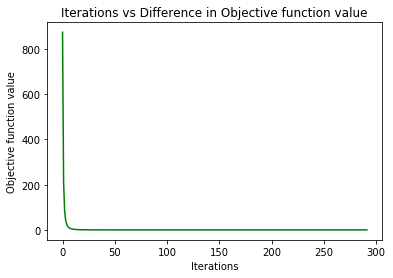

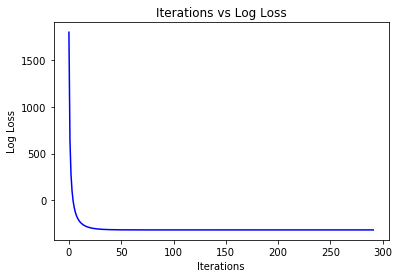

In [11]:
logisticRegression(xTrain,yTrain,xTest,yTest,0.0001,"Bold driver")

In [12]:
#Stochastic gradient descent
def sga(x,y,xt,yt,alpha,method):
    import random
    ii,ll,lloss,history = [],[],[],0
    beta = np.zeros((x.shape[1],1))
    for i in range(1000):
        #drawing a random variable
        index = random.randint(0,x.shape[0])
        X = np.array(x[index,:])
        X = np.reshape(X,(1,len(X)))
        score = X.dot(beta)
        predictions = sigmoid(score)
        Y = y.iloc[[index]]
        error = Y - predictions
        #Computing gradient for the random element
        gradient = np.array(X.T.dot(error))
        print("Gradient",gradient)
        #Bold driver updation
        if method == "Bold driver":
            betaNew = beta + (alpha *(gradient))
            lossOld = logLikelihood(x,y,beta)
            lossNew = logLikelihood(x,y,betaNew)
            logLoss = float(lossNew-lossOld)
            alpha = boldDriver(alpha,lossOld,lossNew)
        #Ada grad updation
        elif method == "adaGrad": 
            alpha,history = adaGrad(gradient,history)
            betaNew = beta + (alpha.T.dot(gradient))
            lossOld = logLikelihood(x,y,beta)
            lossNew = logLikelihood(x,y,betaNew)
            logLoss = float(lossNew-lossOld)
        ii.append(i)
        ll.append(logLoss)
        #Convergence condition
        lloss.append(yt.T.dot(np.log(sigmoid(xt.dot(beta)))) - (1-yt).T.dot(np.log(1-sigmoid(xt.dot(beta)))))
        if (logLoss < 0.000000000000000000000000000001):
            print("Optimal beta found",i+1,betaNew)
            break
        if(i == 999):
            print("Beta did not converge")
        beta = betaNew 
    plt.plot(ii,ll,color = 'green')
    plt.title("Iterations vs Difference in Objective function value")
    plt.xlabel("Iterations")
    plt.ylabel("Objective function value")
    plt.show()
    plt.plot(ii,lloss,color = 'blue')
    plt.title("Iterations vs Log Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Log Loss")
    plt.show()

Gradient [[-0.14285714]
 [-0.02154817]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [-0.5       ]
 [-0.24220577]
 [-0.30753138]
 [-0.49092971]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [-0.5       ]
 [ 0.        ]
 [-0.5       ]]
Gradient [[-0.12857143]
 [-0.02209717]
 [-0.02941176]
 [-0.5       ]
 [ 0.        ]
 [-0.46875   ]
 [-0.34937646]
 [-0.30125523]
 [-0.47857143]
 [-0.42986767]
 [-0.5       ]
 [ 0. 

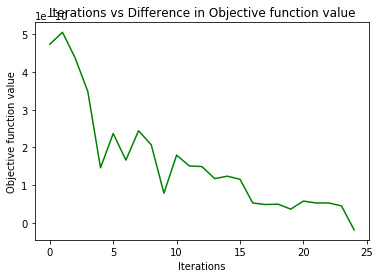

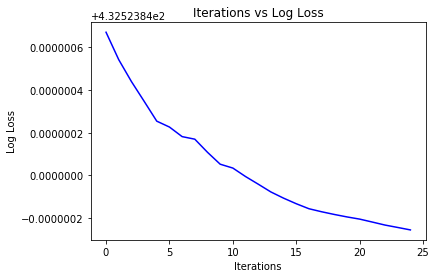

In [56]:
sga(xTrain,yTrain,xTest,yTest,0.0000000000001,"Bold driver")

Gradient [[-0.10714286]
 [-0.03980236]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [-0.5       ]
 [-0.24220577]
 [-0.30753138]
 [-0.49115646]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.5       ]
 [-0.5       ]
 [ 0.        ]
 [-0.5       ]]
Gradient [[-0.14285663]
 [-0.03897872]
 [ 0.        ]
 [-0.49999821]
 [ 0.        ]
 [-0.49999821]
 [-0.44115197]
 [-0.18828385]
 [-0.47947675]
 [-0.49999821]
 [ 0.        ]
 [ 0. 

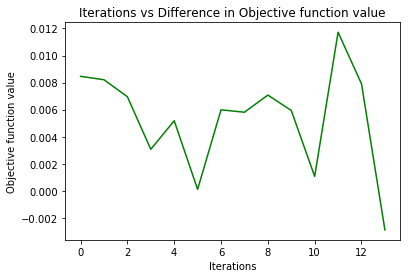

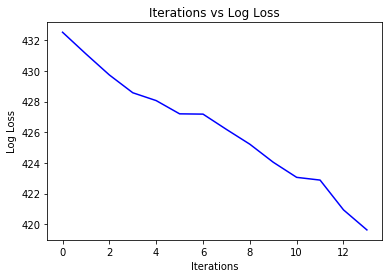

In [14]:
sga(xTrain,yTrain,xTest,yTest,0.0000000000001,"adaGrad")

In [39]:
#Stochastic gradient descent, similar to SGA but considering negative gradient
def sgd(x,y,xt,yt,alpha,method):
    import random
    ii,ll,lloss,history = [],[],[],0
    beta = np.zeros((x.shape[1],1))
    for i in range(1000):
        #drawing a random variable
        index = random.randint(0,x.shape[0])
        X = np.array(x[index,:])
        X = np.reshape(X,(1,len(X)))
        score = X.dot(beta)
        predictions = sigmoid(score)
        Y = y.iloc[[index]]
        error = Y - predictions
        gradient = np.array(X.T.dot(error))
        if method == "Bold driver":
            betaNew = beta - (alpha *(gradient))
            lossOld = logLikelihood(x,y,beta)
            lossNew = logLikelihood(x,y,betaNew)
            logLoss = float(lossOld-lossNew)
            alpha = boldDriver(alpha,lossOld,lossNew)
        elif method == "adaGrad": 
            alpha,history = adaGrad(gradient,history)
            betaNew = beta - (alpha.T.dot(gradient))
            lossOld = logLikelihood(x,y,beta)
            lossNew = logLikelihood(x,y,betaNew)
            logLoss = float(lossOld-lossNew)
        ii.append(i)
        ll.append(logLoss)
        lloss.append(yt.T.dot(np.log(sigmoid(xt.dot(beta)))) - (1-yt).T.dot(np.log(1-sigmoid(xt.dot(beta)))))
        if (logLoss < 0.00000000000000000000001):
            print("Optimal beta found",i+1,betaNew)
            break
        if(i == 999):
            print("Beta did not converge")
        beta = betaNew 
    plt.plot(ii,np.abs(ll),color = 'green')
    plt.title("Iterations vs Difference in Objective function value")
    plt.xlabel("Iterations")
    plt.ylabel("Objective function value")
    plt.show()
    plt.plot(ii,lloss,color = 'blue')
    plt.title("Iterations vs Log Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Log Loss")
    plt.show()

Optimal beta found 15 [[  8.41952314e-13]
 [  2.28812858e-13]
 [  7.03782597e-14]
 [  2.31783693e-12]
 [  7.43008371e-14]
 [  2.43233272e-12]
 [  1.65789583e-12]
 [  8.02768557e-13]
 [  2.49151743e-12]
 [  2.36638432e-12]
 [  2.64990848e-13]
 [  5.05805022e-13]
 [  0.00000000e+00]
 [  1.79159040e-13]
 [  4.13266821e-13]
 [  0.00000000e+00]
 [ -6.41959232e-13]
 [  0.00000000e+00]
 [  1.13867024e-12]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  2.17983210e-12]
 [ -1.27554215e-13]
 [  0.00000000e+00]
 [  6.00000000e-14]
 [  3.73390848e-13]
 [  1.29676326e-12]
 [  0.00000000e+00]
 [  1.24416000e-13]
 [  4.13266821e-13]
 [  0.00000000e+00]
 [  3.45699200e-13]
 [  0.00000000e+00]
 [  5.34966027e-13]
 [  7.04745694e-13]
 [  5.34966027e-13]
 [  3.09586821e-13]
 [  1.34364089e-12]
 [ -1.06993205e-13]
 [  0.00000000e+00]
 [  3.61669018e-13]
 [  3.61159040e-13]
 [  0.00000000e+00]
 [  9.46610233e-13]
 [  7.55391844e-13]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  7.55391844e-13]
 [ -4.92660032e-13

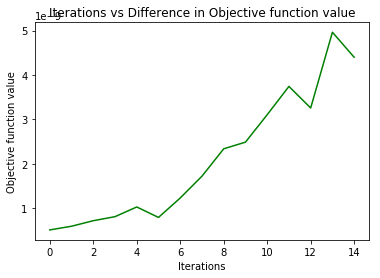

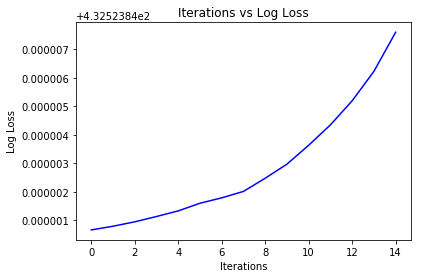

In [50]:
sgd(xTrain,yTrain,xTest,yTest,0.0000000000001,"Bold driver")

Optimal beta found 15 [[  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06]
 [  5.08002162e-06

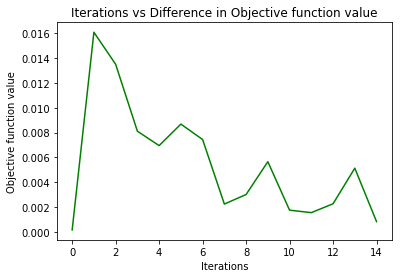

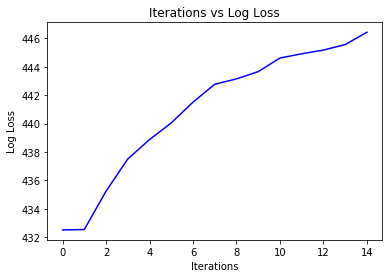

In [47]:
sgd(xTrain,yTrain,xTest,yTest,0.0000000000001,"adaGrad")